I want to create another column that says whether a certain site failure overlapped with others

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, f1_score, roc_curve
from sklearn.model_selection import train_test_split

from tqdm import tqdm

sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)
wq_df['Sampling Location'] = wq_df['Sampling Location'].astype('category')

Having graph showing overlapping failures does not give me additional information on when sites fail in respect to each other. The most highly connected sites in the graph are also the most frequent ones that fail which makes sense. I want to now make a new dataframe that illustrates these connections more completely.

In [2]:
def site_fail_col(df, site, col):
    '''Creates a list of binary responses to whether the measurement failed (1) test \'col\' or not (0)
        in reference to the date of the original \'site\' sample.
        df  = pandas DataFrame from which to draw all data
        site = sampling location being tested. When site fails, what other sites fail?
        col = parameter being tested
        '''
    column = col + ' Failure'
    fail_date_df = df[(df['Sampling Location'] == site) & (df[column] == 1)]['Sample Date']
    site_set = set([(i.year, i.month) for i in fail_date_df])
    
    site_col_overlap = []
    
    # Checks to see if sample date is in set of dates where `site` failed  
    # if failures overlap, appends 1 to site_col_overlap
    for tup in df.itertuples():
        if (tup[42] == 1) & ((tup[2].year, tup[2].month) in site_set):
            site_col_overlap.append(1)
        else:
            site_col_overlap.append(0)
    
    return site_col_overlap

In [3]:
from tqdm import tqdm

chl_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_chl'
    site_list = site_fail_col(wq_df, site, 'Top Active Chlorophyll \'A\' (µg/L)')
    
    chl_overlap_df[col_name] = site_list

    
ent_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_ent'
    site_list = site_fail_col(wq_df, site, 'Top Enterococci Bacteria (Cells/100mL)')
    
    ent_overlap_df[col_name] = site_list


pho_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_pho'
    site_list = site_fail_col(wq_df, site, 'Top Ortho-Phosphorus (mg/L)')
    
    pho_overlap_df[col_name] = site_list


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:17<00:00,  3.14it/s]


For these graphs, the site along the x-axis is the one who's prediction ability we are testing. If site_x fails, then what is the probability that site_y fails too. I made it so the sum of each row and column had to be greater than 1 so if site_x fails, at least 1 of the shown sites should fail as well.

(16, 26)


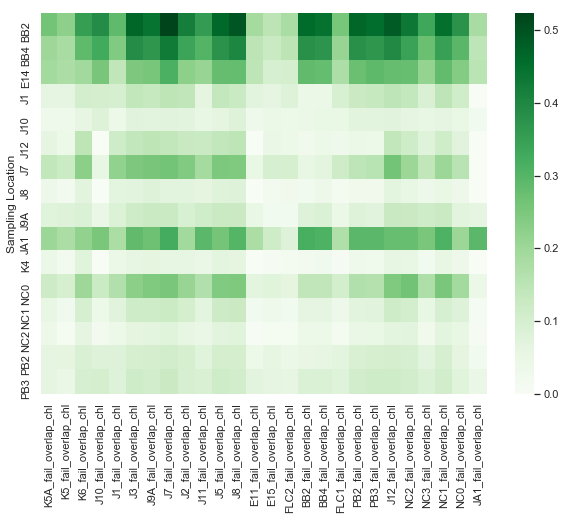

In [4]:
chl_means_df = chl_overlap_df.groupby('Sampling Location').mean()
for i, row in chl_means_df.iterrows():
    if row.sum() <= 1:
        chl_means_df = chl_means_df.drop(index=[i])

for col in chl_means_df:
    if chl_means_df[col].sum() <= 1:
        chl_means_df = chl_means_df.drop(columns=[col])
        
print(chl_means_df.shape)    
_ = plt.figure(figsize=(10, 7))
_ = sns.heatmap(data=chl_means_df, cmap='Greens')

(13, 16)


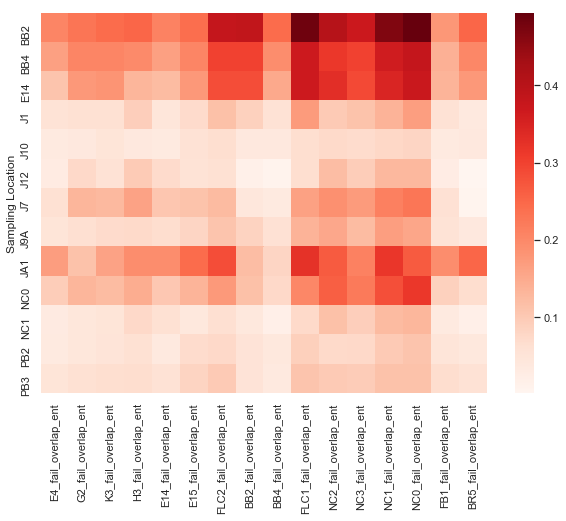

In [5]:
ent_means_df = ent_overlap_df.groupby('Sampling Location').mean()
for i, row in ent_means_df.iterrows():
    if row.sum() <= 1:
        ent_means_df = ent_means_df.drop(index=[i])
for col in ent_means_df:
    if ent_means_df[col].sum() <= 1:
        ent_means_df = ent_means_df.drop(columns=[col])
print(ent_means_df.shape)
_ = plt.figure(figsize=(10, 7))
_ = sns.heatmap(data=ent_means_df, cmap='Reds')

(15, 14)


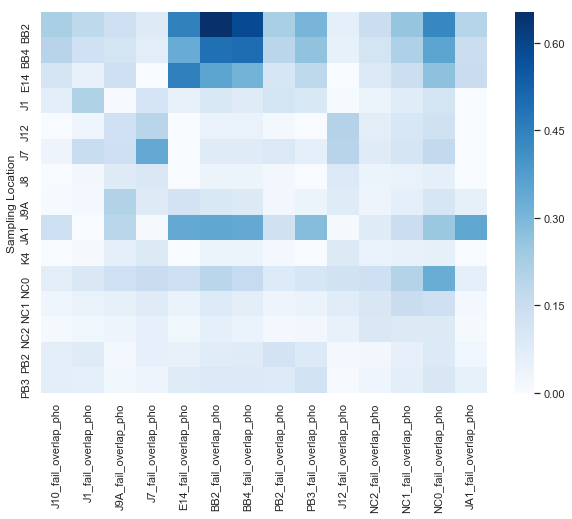

In [6]:
pho_means_df = pho_overlap_df.groupby('Sampling Location').mean()
for i, row in pho_means_df.iterrows():
    if row.sum() <= 1:
        pho_means_df = pho_means_df.drop(index=[i])
for col in pho_means_df:
    if pho_means_df[col].sum() <= 1:
        pho_means_df = pho_means_df.drop(columns=[col])
print(pho_means_df.shape)
_ = plt.figure(figsize=(10, 7))
_ = plt.xticks()
_ = sns.heatmap(data=pho_means_df, cmap='Blues')

With the above heatmaps, I am able to see which sites I should focus my efforts on. For instance in the chlorophyll heatmap (green), J11 appears to have a relationship to a variety of sites. I will explore this later as well.

# Inverse Distance Weighted Maps

It will be helpful for my analysis to put the heatmaps in the context of geography. For the following graphs, I took into account the distance between each site using latitude and longitude as well as the frequency of overlap. In following Tobler's First Law of Geography, sites that are closer together will have a greater likelihood of influencing each other. 

The following function was repurposed from [this](https://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python) Stack Overflow thread.


In these visualizations, the darkest areas are the sites that predict a failure at the target site.

In [7]:
def main(df, site, param):
    # Setup: Generate data...
    nx, ny = 50, 50
    x = df['Long']
    y = df['Lat']
    z = df[site + '_fail_overlap_' + param]
    xi = np.linspace(x.min(), x.max(), nx)
    yi = np.linspace(y.min(), y.max(), ny)
    xi, yi = np.meshgrid(xi, yi)
    xi, yi = xi.flatten(), yi.flatten()

    # Calculate IDW
    grid1 = simple_idw(x,y,z,xi,yi)
    grid1 = grid1.reshape((nx, ny))

    # Select color for graphs
    if param == 'chl':
        color = 'Greens'
    elif param == 'ent':
        color = 'Reds'
    elif param == 'pho':
        color = 'Blues'
    # Comparisons...
    if sum(z) > 0:
        site_info = df[df.index == site]
        plot(x,y,z,grid1,color)
        plt.title('Heatmap Indicating Sites Overlapping with ' + site)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.scatter(x=site_info['Long'], y=site_info['Lat'],
                    marker='o', c='k', label=site)
        plt.legend()
        plt.show()

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)


def plot(x,y,z,grid,color):
    
    plt.figure()
    plt.tight_layout()
    plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
               cmap=color)
    plt.colorbar()

Next I want to create each parameter's joined dataframe using the overlap dataframes I created previously. These will be used to produce the IDW graphs.

In [8]:
lat = wq_df.groupby('Sampling Location')['Lat'].mean()
long = wq_df.groupby('Sampling Location')['Long'].mean()

chl_df = chl_overlap_df.groupby('Sampling Location').mean()
chl_joined_df = chl_df.join(lat)
chl_joined_df = chl_joined_df.join(long)

ent_df = ent_overlap_df.groupby('Sampling Location').mean()
ent_joined_df = ent_df.join(lat)
ent_joined_df = ent_joined_df.join(long)

pho_df = pho_overlap_df.groupby('Sampling Location').mean()
pho_joined_df = pho_df.join(lat)
pho_joined_df = pho_joined_df.join(long)

## Chlorophyll

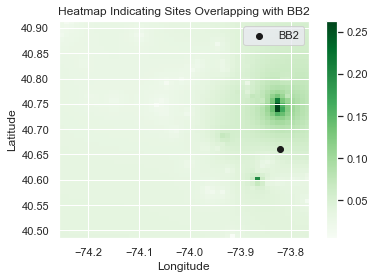

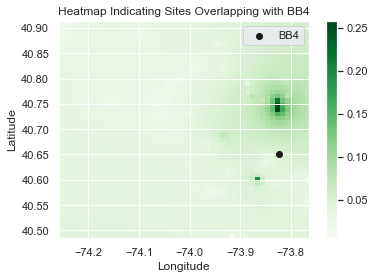

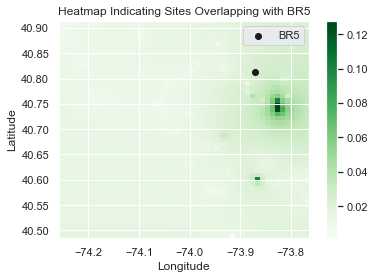

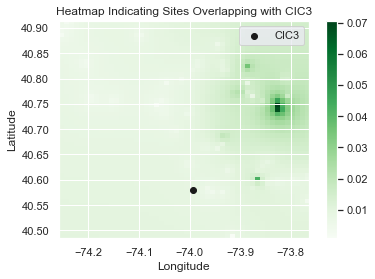

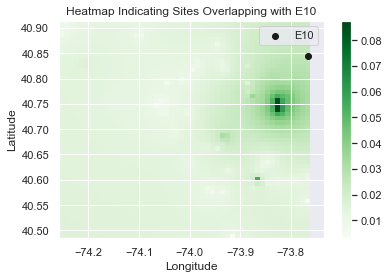

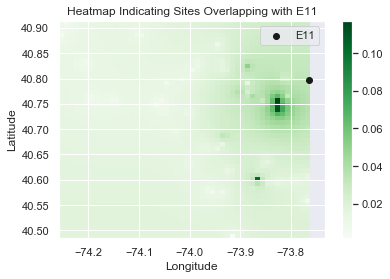

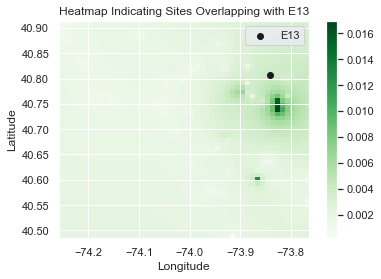

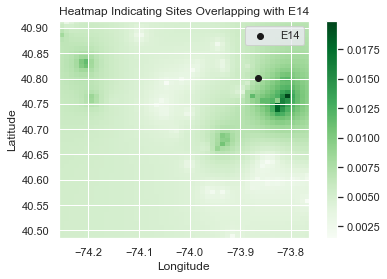

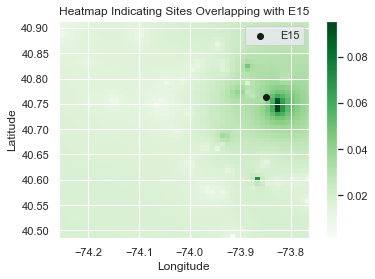

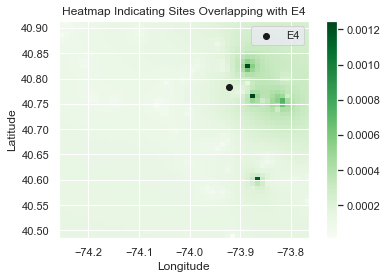

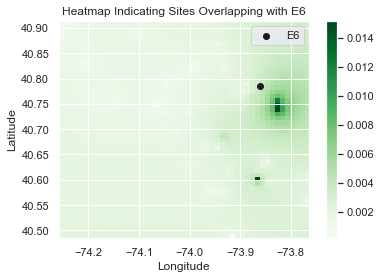

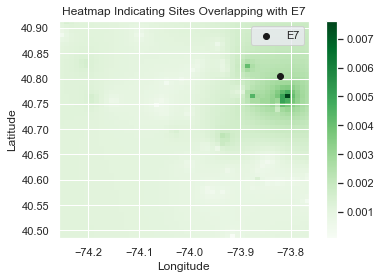

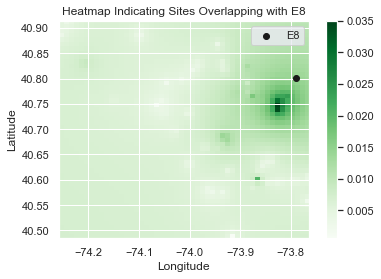

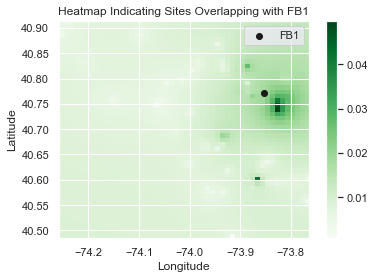

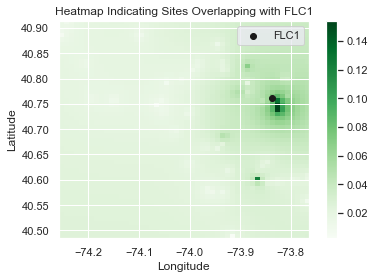

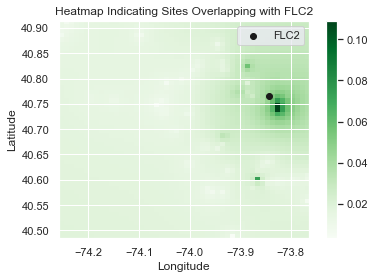

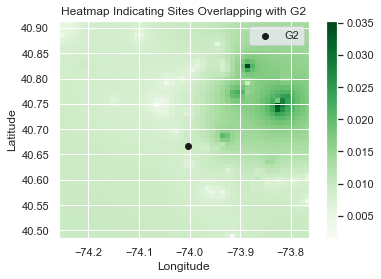

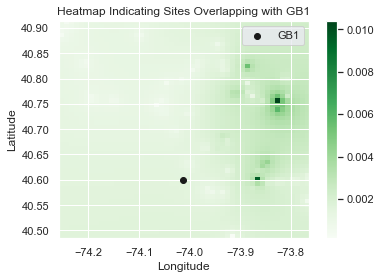

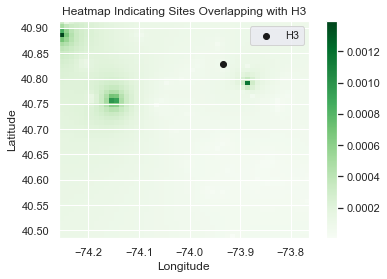

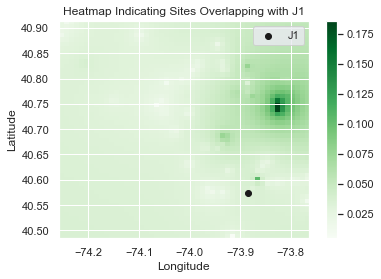

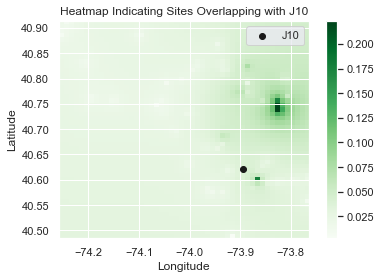

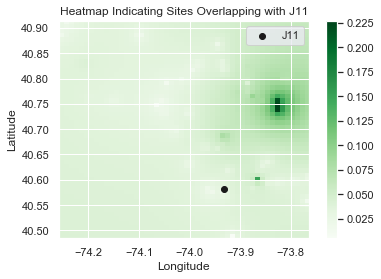

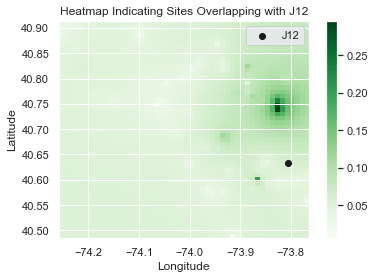

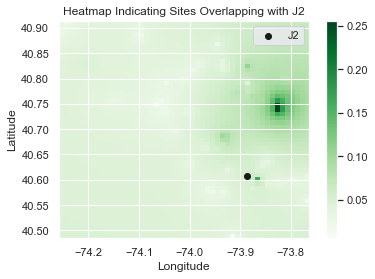

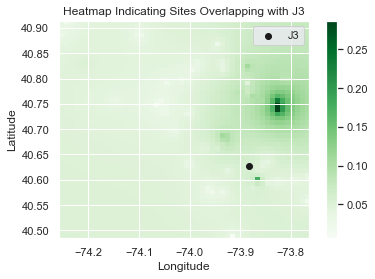

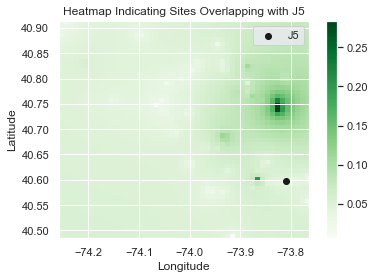

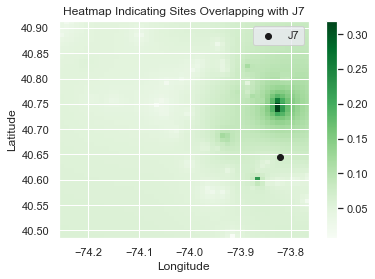

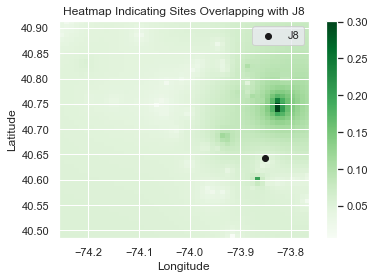

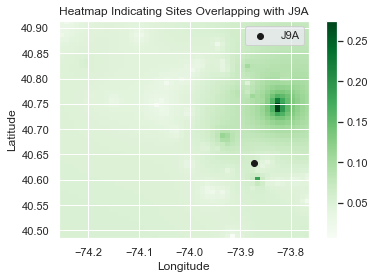

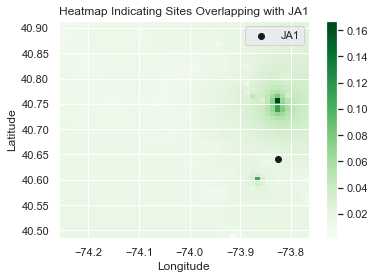

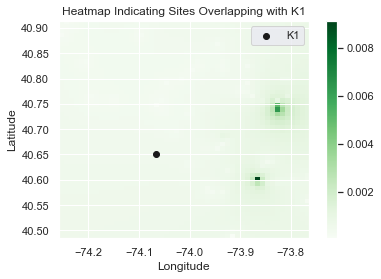

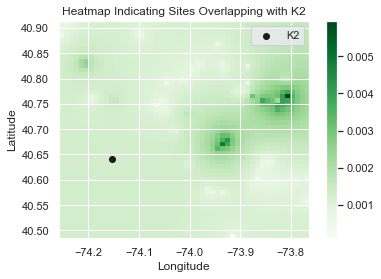

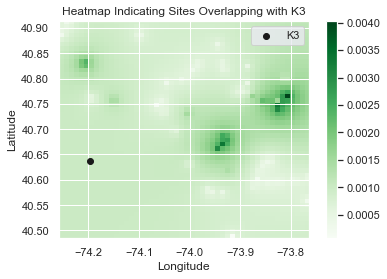

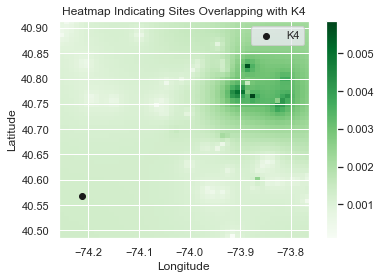

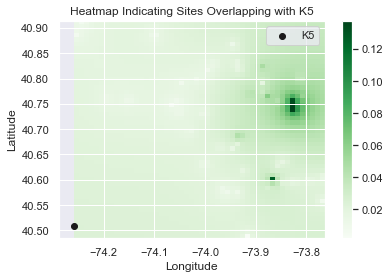

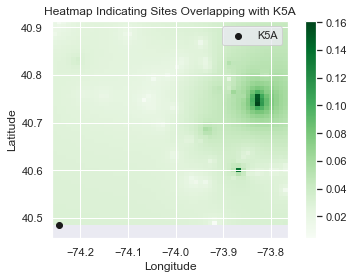

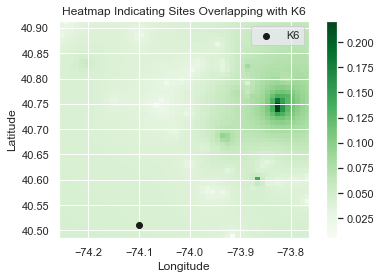

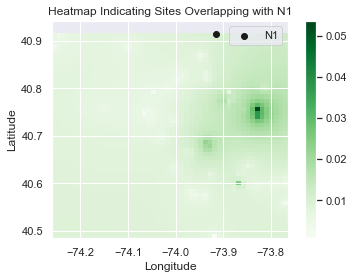

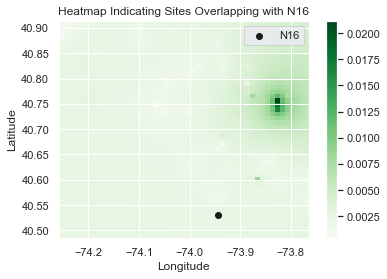

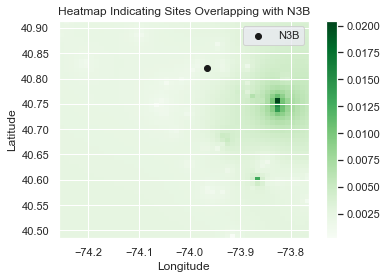

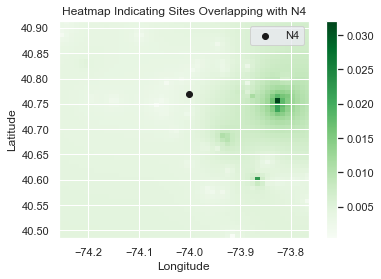

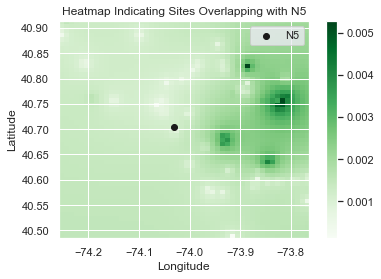

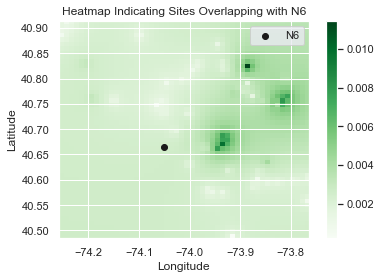

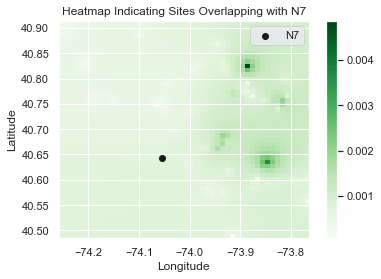

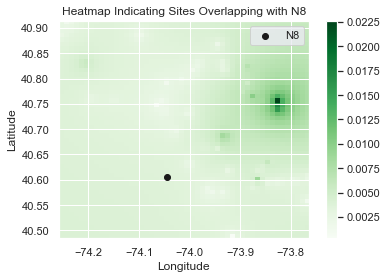

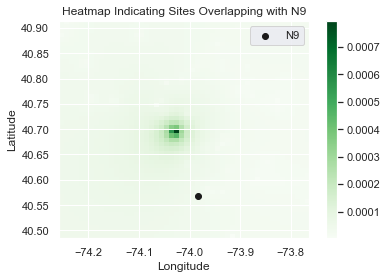

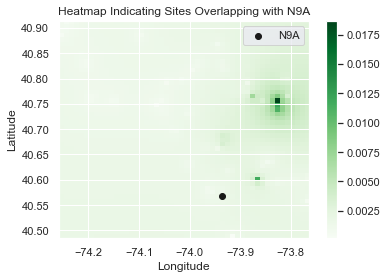

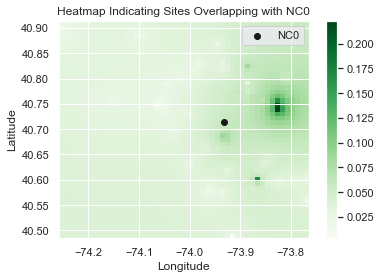

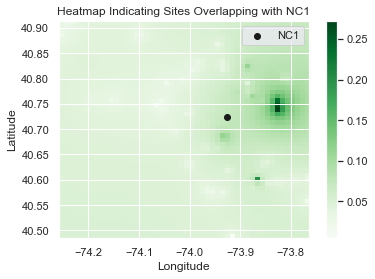

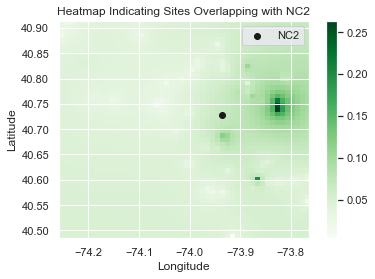

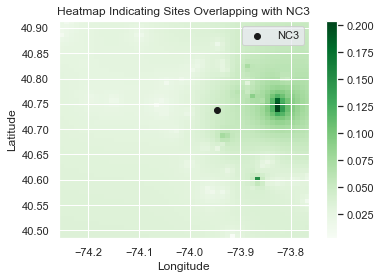

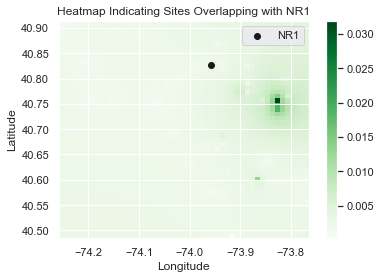

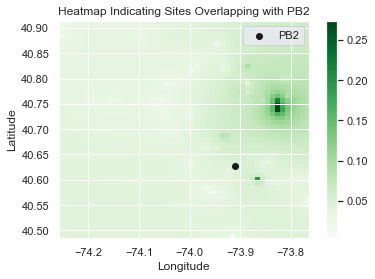

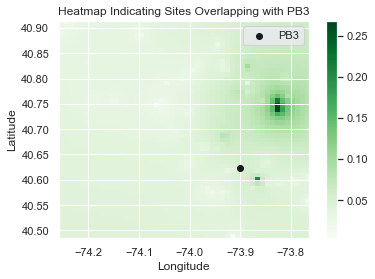

In [9]:
for site in chl_joined_df.index:
    main(chl_joined_df, site, 'chl')

## Enterococcus

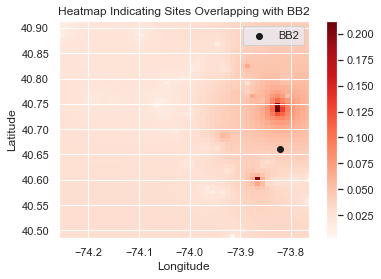

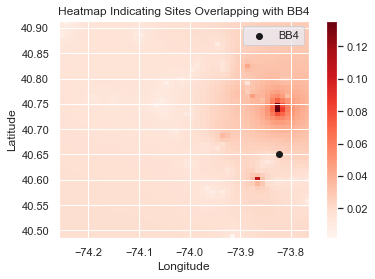

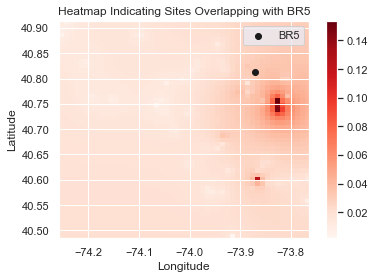

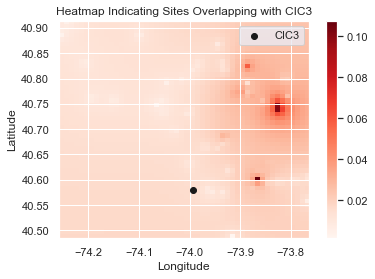

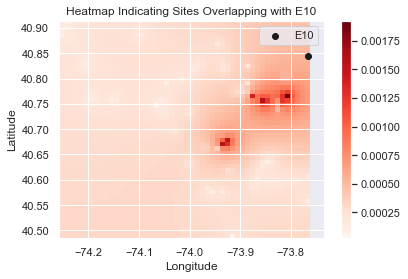

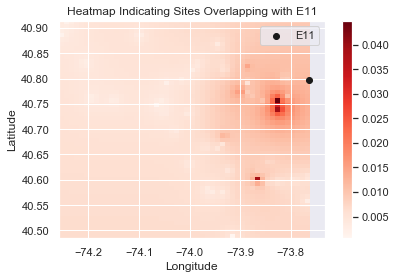

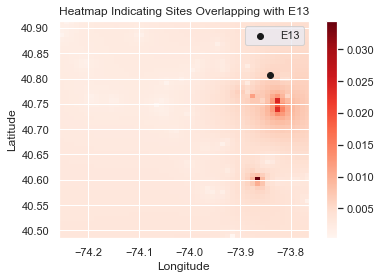

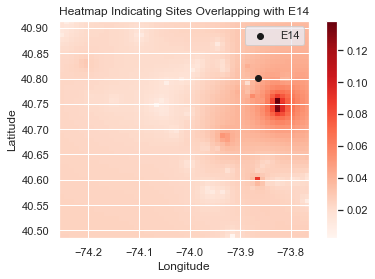

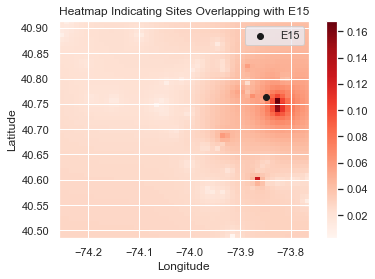

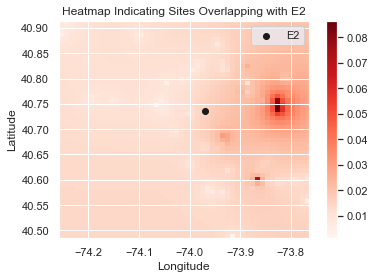

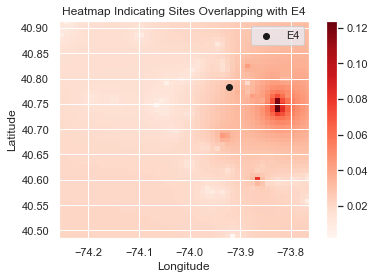

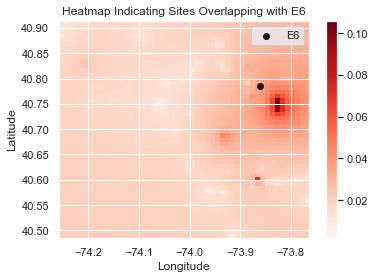

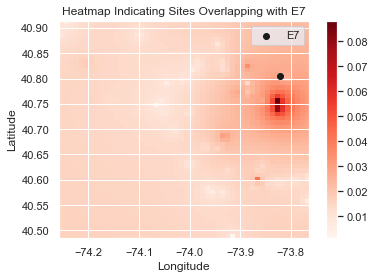

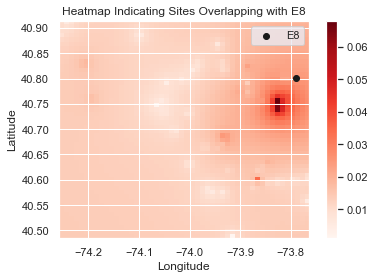

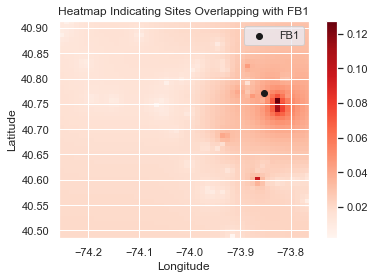

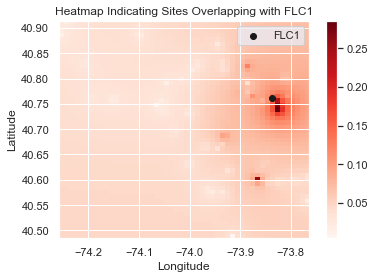

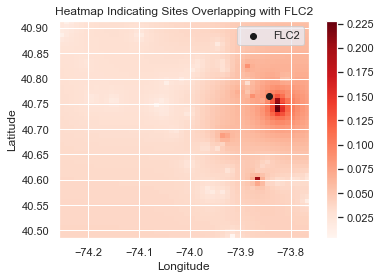

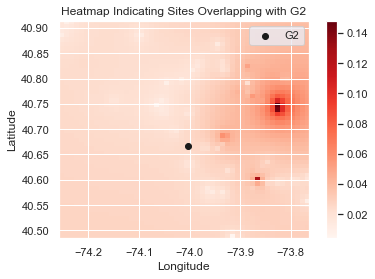

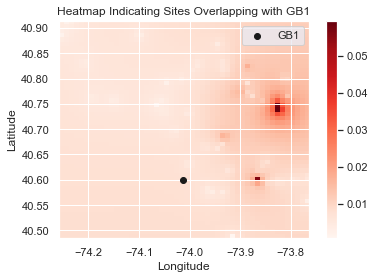

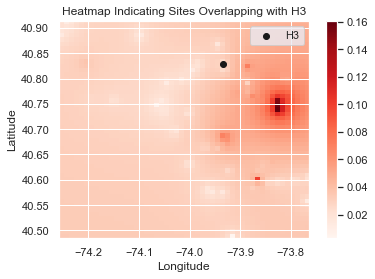

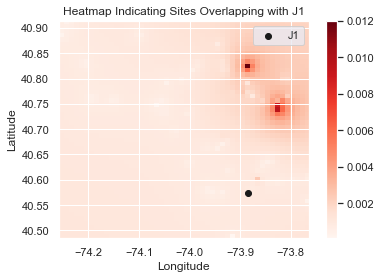

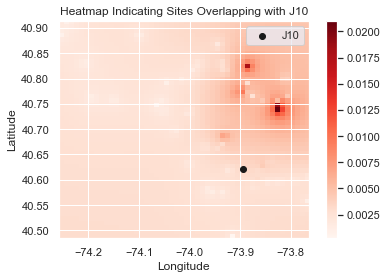

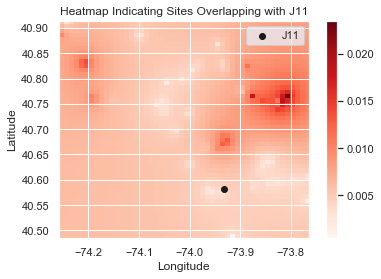

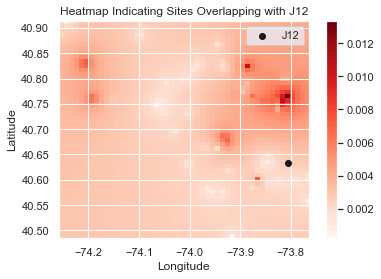

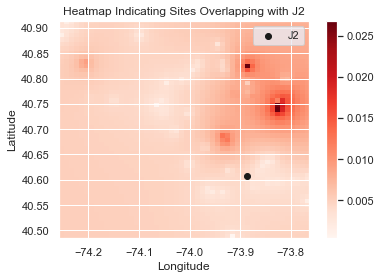

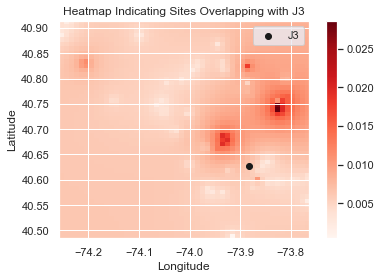

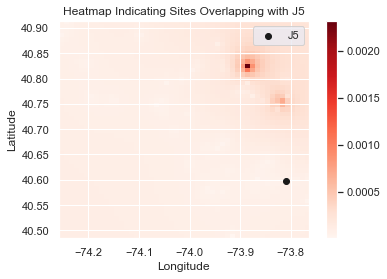

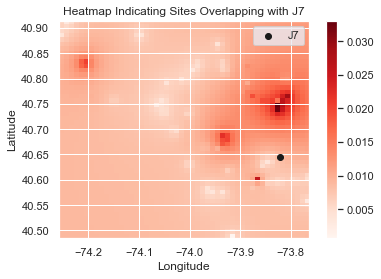

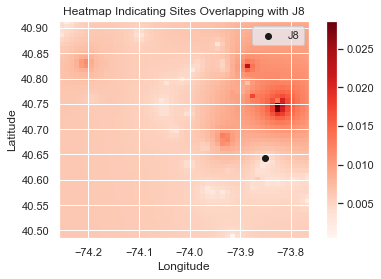

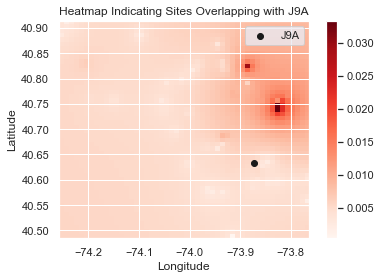

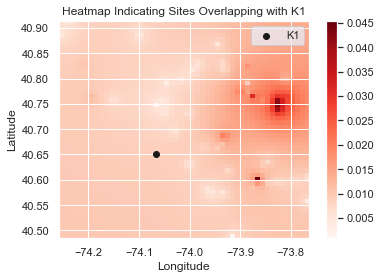

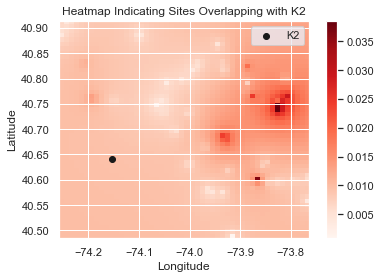

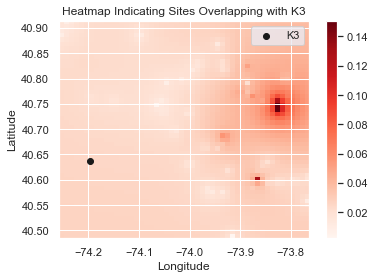

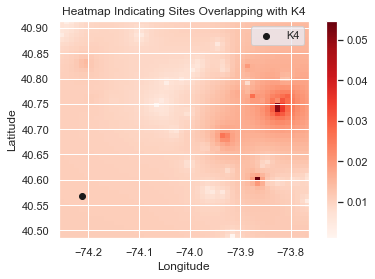

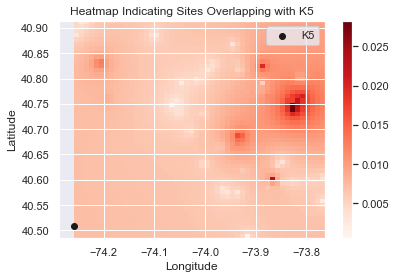

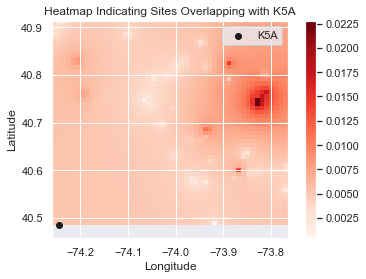

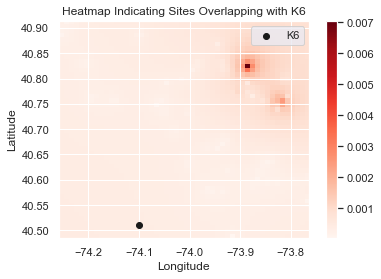

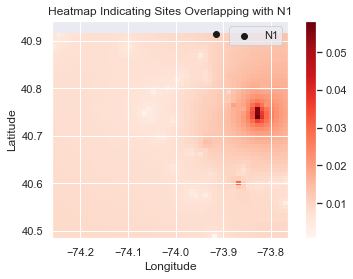

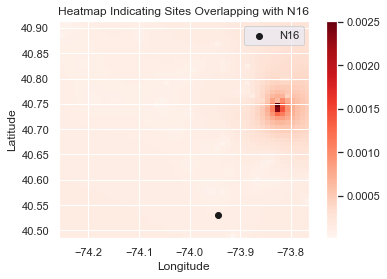

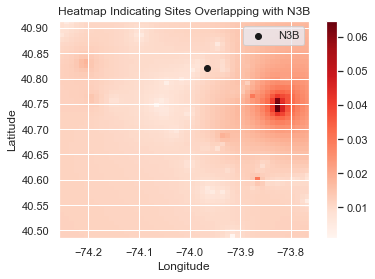

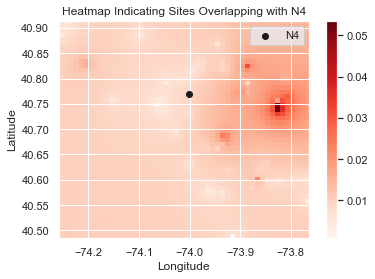

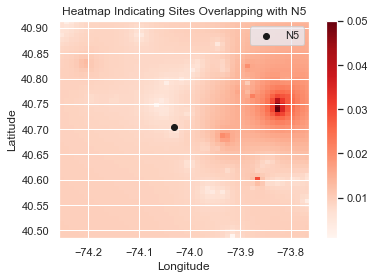

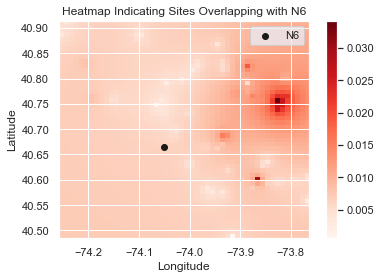

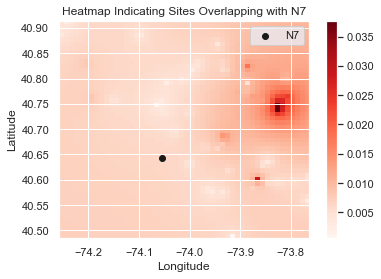

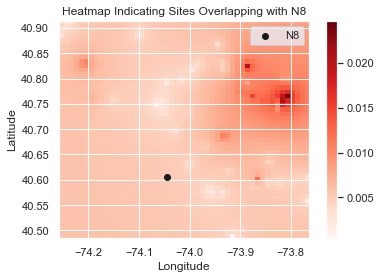

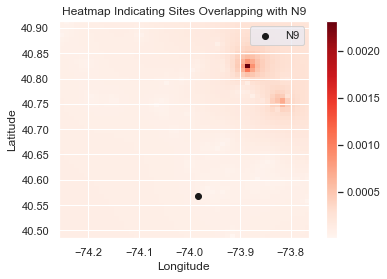

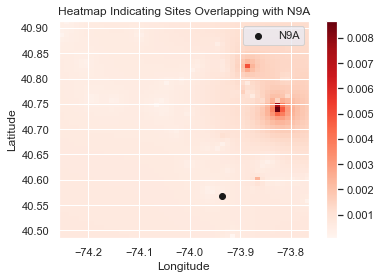

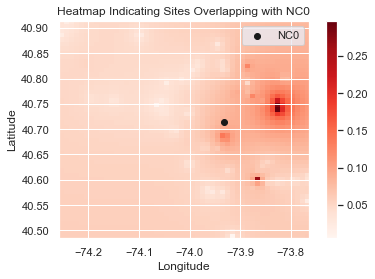

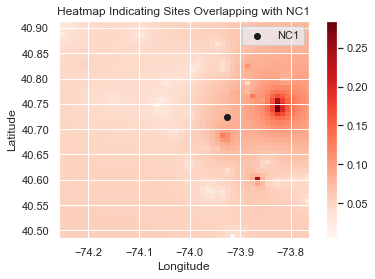

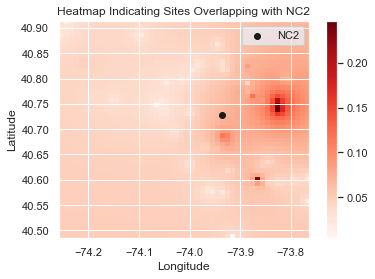

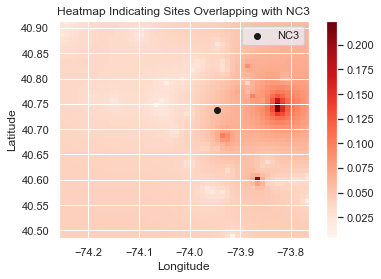

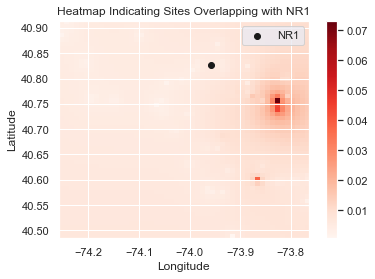

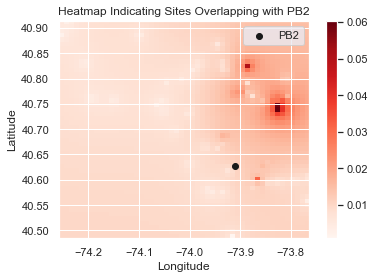

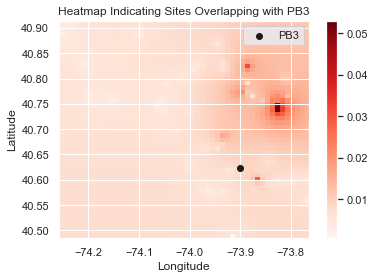

In [10]:
for site in ent_joined_df.index:
    main(ent_joined_df, site, 'ent')

## Phosphorus

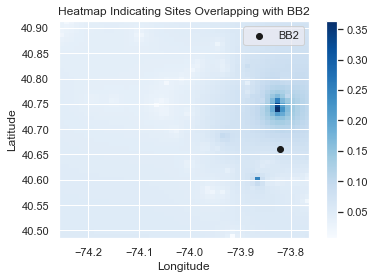

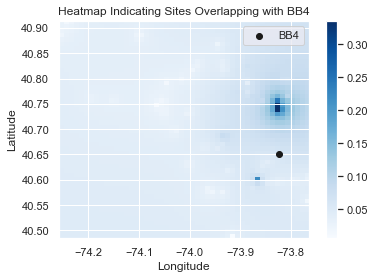

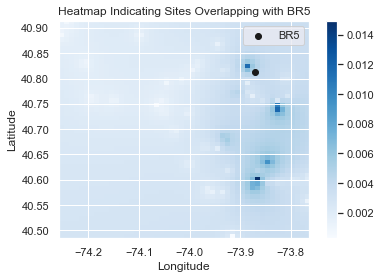

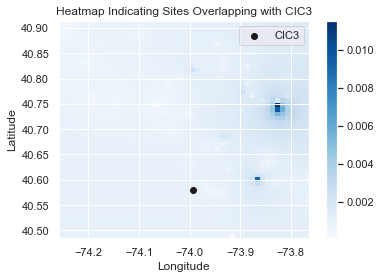

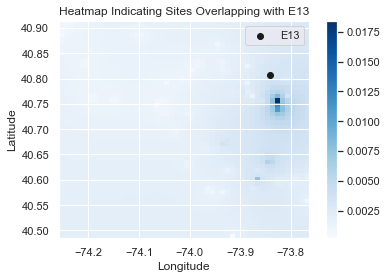

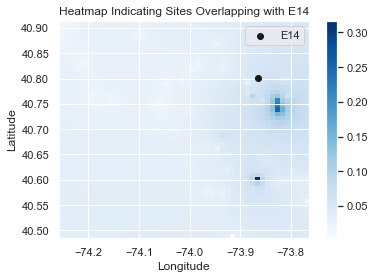

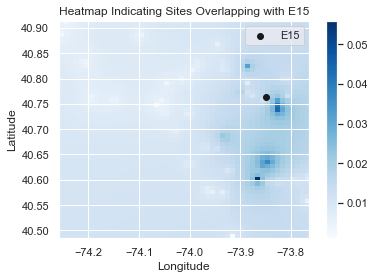

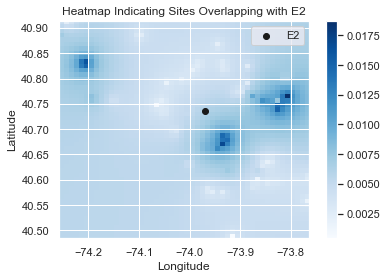

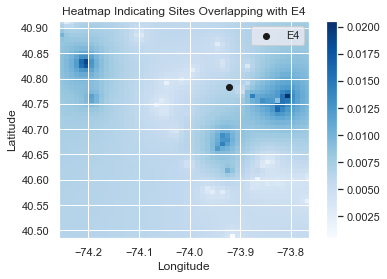

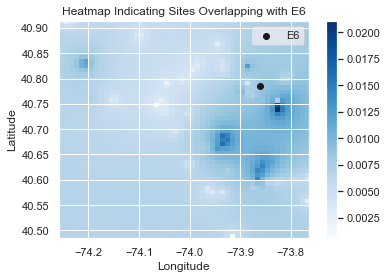

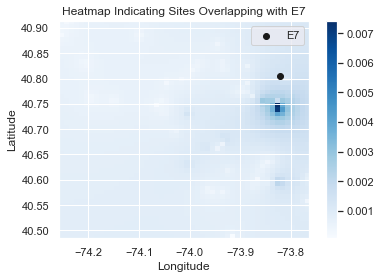

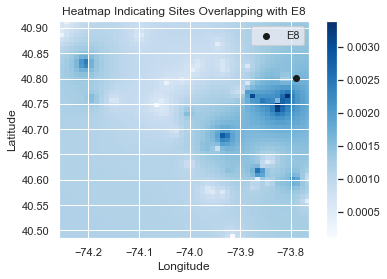

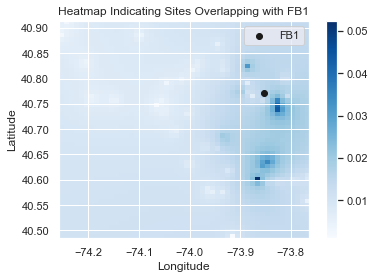

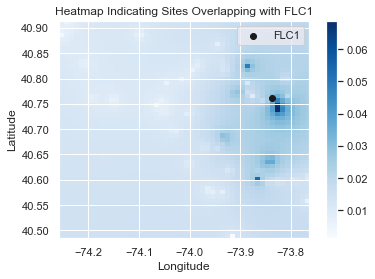

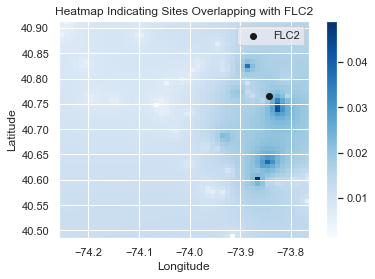

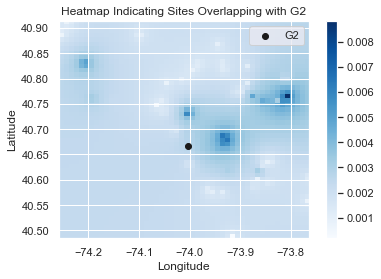

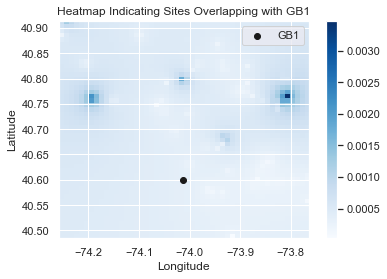

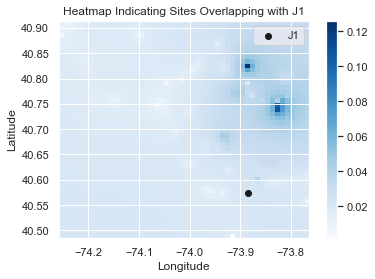

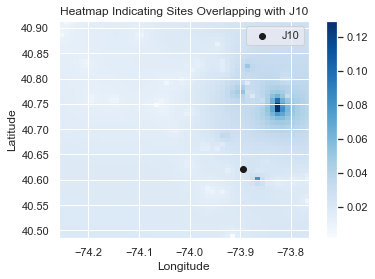

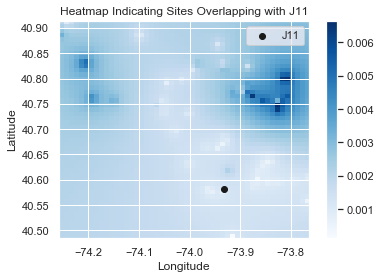

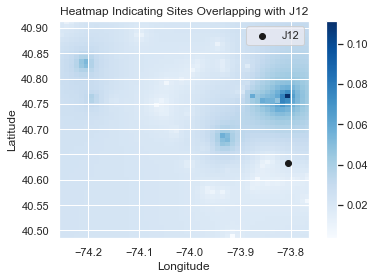

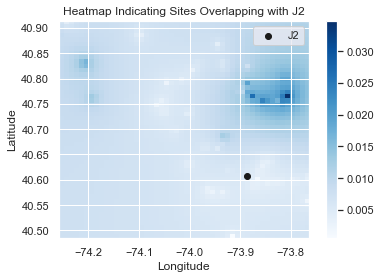

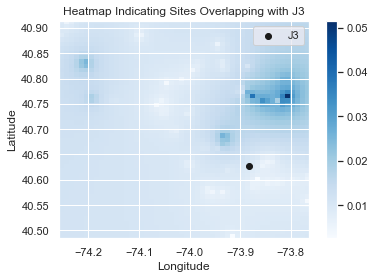

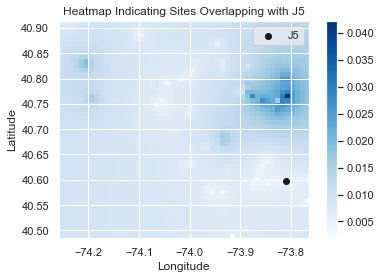

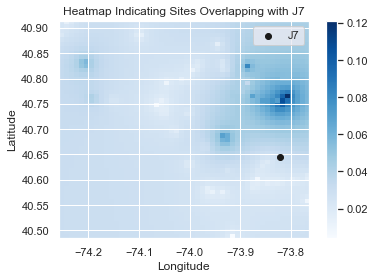

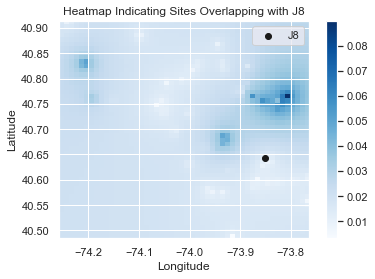

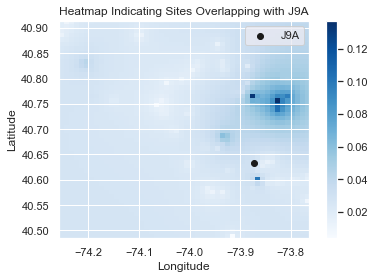

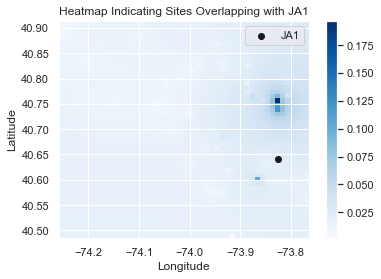

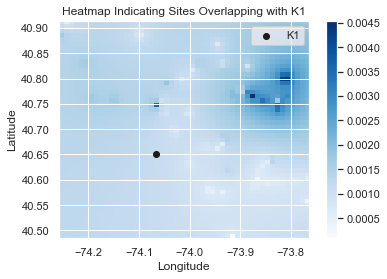

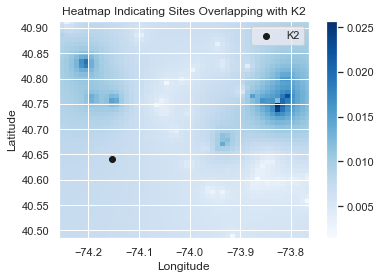

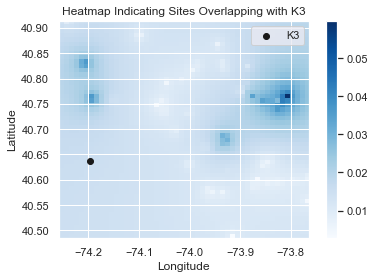

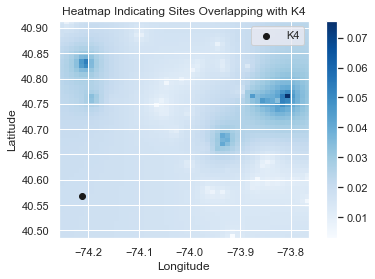

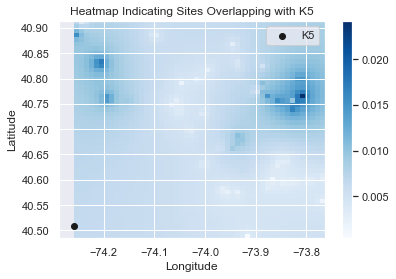

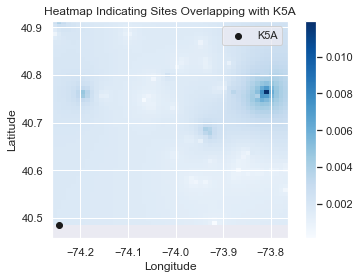

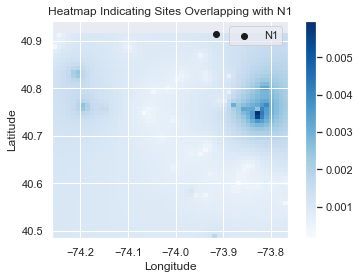

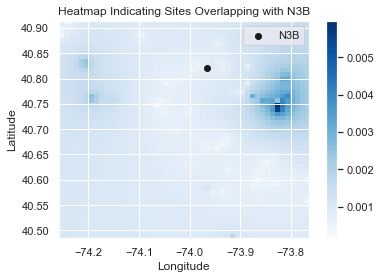

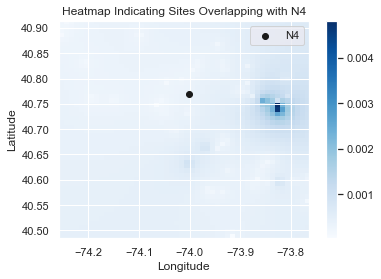

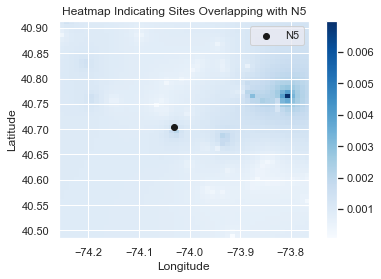

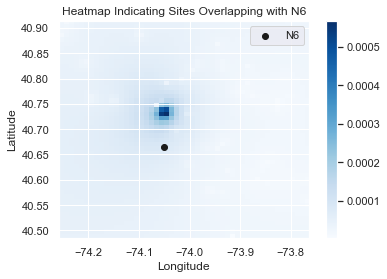

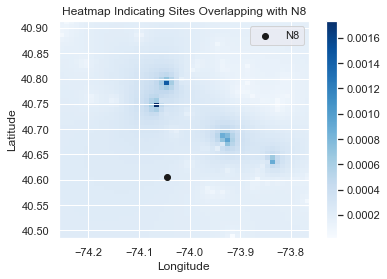

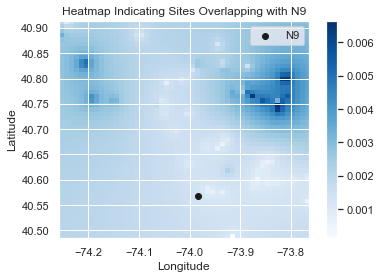

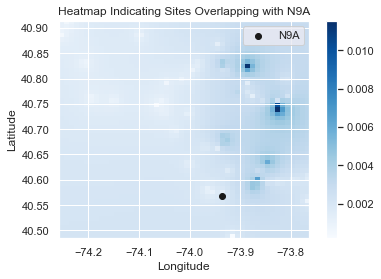

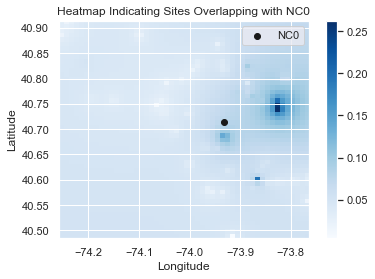

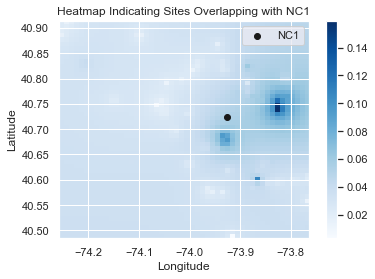

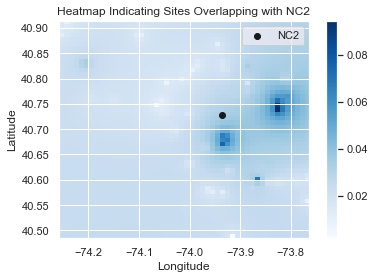

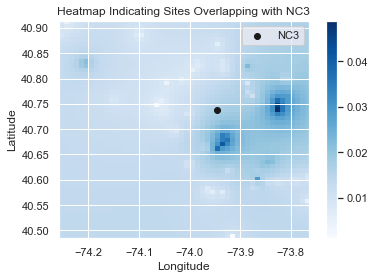

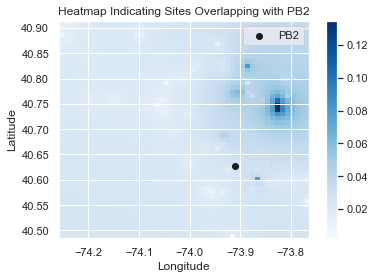

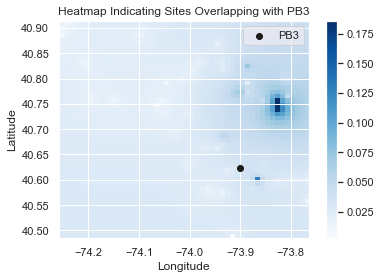

In [11]:
for site in pho_joined_df.index:
    main(pho_joined_df, site, 'pho')

# Choosing Sites to Investigate Further

In order determine which sites to target as predictors of quality elsewhere, I will look at a few different features of the heatmaps. The following ar in no particular order and are meant to be used in conjunction with each other.

- **Map Scale**
    If the maximum on the color bar is above 0.1, then I believe that the site may have good prediction power.

- **Geography** 
    If a site is far away from the sites where it has fairly high overlap, then I believe it is reasonable that these overlaps are more anomalous than caused by the actual flow of water between sites.

- **Overall Overlap**
    If a site overlaps with a lot of other sites, it may be worthwhile to investigate whether this site could predict for a large swath of sites at once. If it proved successful, then it could be a huge time/money saver for state agencies performing sampling.
    

## Sites for Further Investigation

These sites appear to have high predictability for each parameter. Some are greater than others, but this variation will show me gradiations in the effectiveness of the model.

### Site List

- `BB2`, `E14`, `FLC1`, `J8`, `K6`, `NC0`, `PB3`



I am going to work through these systematically. I will showcase the full process first and show fewer steps for later sites.

# Model Selection and Testing

To create my dataframe, I need to combine `wq_df` with the columns showing overlap in failures for each site I am investigating further.

In [41]:
chl_class_df = wq_df.join(chl_overlap_df.loc[:, ['BB2_fail_overlap_chl',
                                                 'E14_fail_overlap_chl', 
                                                 'FLC1_fail_overlap_chl', 
                                                 'J8_fail_overlap_chl',
                                                 'K6_fail_overlap_chl',
                                                 'NC0_fail_overlap_chl',
                                                 'PB3_fail_overlap_chl']])

ent_class_df = wq_df.join(ent_overlap_df.loc[:, ['BB2_fail_overlap_ent',
                                                 'E14_fail_overlap_ent', 
                                                 'FLC1_fail_overlap_ent', 
                                                 'J8_fail_overlap_ent',
                                                 'K6_fail_overlap_ent',
                                                 'NC0_fail_overlap_ent',
                                                 'PB3_fail_overlap_ent']])

pho_class_df = wq_df.join(pho_overlap_df.loc[:, ['BB2_fail_overlap_pho',
                                                 'E14_fail_overlap_pho', 
                                                 'FLC1_fail_overlap_pho', 
                                                 'J8_fail_overlap_pho',
                                                 'K6_fail_overlap_pho',
                                                 'NC0_fail_overlap_pho',
                                                 'PB3_fail_overlap_pho']])

## Data Preparation

### Resampling
All of the target variables I am working with are heavily imbalanced, so I need to have a way to fix this issue. The following function resamples so there are 2000 data of each target class. Since there are ~1000 positive responses in the entire dataset, I did not feel comfortable that upsampling the positive responses to ~20,000 would be an accurate representation of the data, and downsampling the negative responses to ~1000 would leave me with very few data points. I decided on a middle ground of 4000 of each.

In [42]:
def balance(df, site):
    '''Resamples dataset to balance target variable categorizations.'''
    
    target = site + '_fail_overlap_chl'
    int_df = df.select_dtypes(include=[float, 'int64'])
    int_df = int_df.drop(columns=['Lat', 'Long'])
    
    class0 = int_df[int_df[target] == 0]
    class1 = int_df[int_df[target] == 1]
    nclass0 = len(class0)
    nclass1 = len(class1)
    class0_resampled = np.random.choice(class0.index, size=4000, replace=True)
    class1_resampled = np.random.choice(class1.index, size=4000, replace=True)
    resampled_int_df = int_df.iloc[class0_resampled]
    resampled_int_df = resampled_int_df.append(int_df.iloc[class1_resampled])
    
    return resampled_int_df

### Splitting

It is important to split the data before making tuning models in order to avoid leakage from the test data into the training set.

In [43]:
balanced_overlap_df_chl = balance(chl_class_df, 'BB2')

features = balanced_overlap_df_chl.iloc[:, :38].copy()
target = balanced_overlap_df_chl.loc[:, 'BB2_fail_overlap_chl'].copy()

x_train, x_test, target_train, target_test \
    = train_test_split(features, target, test_size=0.3, random_state=42)

## Feature Selection

I need to see which features I can drop. I am going to use Recursive Feature Elimination (RFE). RFE ranks the features and eliminates the worst predictors. First it is trained on the initial set of features and then it eliminates more based on the coef_ or feature_importances_ attribute.

In [44]:
estimator = RandomForestClassifier(n_estimators=10, random_state=42)
selector = RFE(estimator, 10, step=1)
selector = selector.fit(x_train, target_train)
print(selector.support_)
print(selector.ranking_)

[ True  True  True False  True  True False False False False False False
 False False False False False  True False False False  True  True False
 False False False False False False False False False False False False
  True  True]
[ 1  1  1 20  1  1 18  9  4 12  5 15 13 17 11 21  3  1  6 19  2  1  1  8
 10 14  7 16 22 23 25 26 24 27 28 29  1  1]


Now that I have the best features, I want to make sure that there are no instances of colinearity within them.

In [45]:
best_features = x_train[x_train.columns[selector.support_]].copy()
best_features.head()

,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Bottom Sample Depth (ft),Top Salinity (psu),Bottom PH,Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Ortho-Phosphorus (mg/L) Failure,Month
15341,24.79,24.59,19.0,18.0,24.50,7.50,0.258,1.960,1,7
4058,23.69,22.50,39.0,40.0,24.95,7.82,0.209,1.450,1,6
15481,21.66,21.59,6.4,16.0,24.98,7.38,0.290,0.484,1,8
22315,19.05,17.33,42.0,37.0,19.18,7.81,0.050,0.720,0,6
14542,20.47,20.43,24.0,20.0,24.77,7.51,0.290,0.478,1,10


In [46]:
best_features.join(target_train).corr()

,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Bottom Sample Depth (ft),Top Salinity (psu),Bottom PH,Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Ortho-Phosphorus (mg/L) Failure,Month,BB2_fail_overlap_chl
Top Sample Temperature (ºC),1.000000,0.935688,-0.193760,-0.206364,0.080133,-0.221071,0.257191,0.122655,0.393181,0.513082,0.399345
Bottom Sample Temperature (ºC),0.935688,1.000000,-0.182833,-0.208990,0.171059,-0.216126,0.219919,0.038625,0.379876,0.554271,0.382704
Site Actual Depth (ft),-0.193760,-0.182833,1.000000,0.948538,-0.043056,0.018745,-0.383178,-0.166304,-0.425440,-0.030807,-0.417295
Bottom Sample Depth (ft),-0.206364,-0.208990,0.948538,1.000000,-0.048339,0.015771,-0.341741,-0.136739,-0.404703,-0.044194,-0.397490
Top Salinity (psu),0.080133,0.171059,-0.043056,-0.048339,1.000000,0.407836,-0.160050,-0.420258,0.118869,0.146831,0.118183
Bottom PH,-0.221071,-0.216126,0.018745,0.015771,0.407836,1.000000,-0.224980,-0.206842,-0.126184,-0.283048,-0.120362
Top Ortho-Phosphorus (mg/L),0.257191,0.219919,-0.383178,-0.341741,-0.160050,-0.224980,1.000000,0.552857,0.671183,0.083181,0.654165
Top Total Kjeldhal Nitrogen (mg/L),0.122655,0.038625,-0.166304,-0.136739,-0.420258,-0.206842,0.552857,1.000000,0.170470,-0.043915,0.157686
Top Ortho-Phosphorus (mg/L) Failure,0.393181,0.379876,-0.425440,-0.404703,0.118869,-0.126184,0.671183,0.170470,1.000000,0.139863,0.967476
Month,0.513082,0.554271,-0.030807,-0.044194,0.146831,-0.283048,0.083181,-0.043915,0.139863,1.000000,0.129162


In [47]:
x_train = x_train.drop(columns=['Bottom Sigma-T (kg/m3)',
                                'Bottom Conductivity (S/m)',
                                'Top Ammonium (mg/L)',
                                'Top Total Kjeldhal Nitrogen (mg/L)',
                                'Top Ortho-Phosphorus (mg/L)',
                                ]
                       ).copy()

I am going to do RFE a second time now that I have eliminated colinear columns.

In [48]:
estimator = RandomForestClassifier(n_estimators=10)
selector = RFE(estimator, 10, step=1)
selector = selector.fit(x_train, target_train)
best_features = x_train[x_train.columns[selector.support_]].copy()
best_features.head()

,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Bottom Sample Depth (ft),Bottom Salinity (psu),"CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)",Top Silica (mg/L),Top Dissolved Organic Carbon (mg/L),Top Ortho-Phosphorus (mg/L) Failure,Month
15341,24.79,24.59,19.0,18.0,25.25,1.62,3.300,3.68,1,7
4058,23.69,22.50,39.0,40.0,26.24,1.80,1.020,4.10,1,6
15481,21.66,21.59,6.4,16.0,25.06,4.04,2.505,2.21,1,8
22315,19.05,17.33,42.0,37.0,23.35,6.25,2.045,2.96,0,6
14542,20.47,20.43,24.0,20.0,25.23,5.40,3.150,3.39,1,10


In [49]:
best_features.join(target_train).corr()

,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Bottom Sample Depth (ft),Bottom Salinity (psu),"CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)",Top Silica (mg/L),Top Dissolved Organic Carbon (mg/L),Top Ortho-Phosphorus (mg/L) Failure,Month,BB2_fail_overlap_chl
Top Sample Temperature (ºC),1.000000,0.935688,-0.193760,-0.206364,0.157557,-0.344666,0.143552,0.177863,0.393181,0.513082,0.399345
Bottom Sample Temperature (ºC),0.935688,1.000000,-0.182833,-0.208990,0.163322,-0.358304,0.145839,0.086031,0.379876,0.554271,0.382704
Site Actual Depth (ft),-0.193760,-0.182833,1.000000,0.948538,0.005762,0.063115,-0.198832,-0.148470,-0.425440,-0.030807,-0.417295
Bottom Sample Depth (ft),-0.206364,-0.208990,0.948538,1.000000,0.022833,0.060770,-0.185116,-0.126598,-0.404703,-0.044194,-0.397490
Bottom Salinity (psu),0.157557,0.163322,0.005762,0.022833,1.000000,-0.060416,-0.243055,-0.133272,0.122702,0.137872,0.126980
"CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)",-0.344666,-0.358304,0.063115,0.060770,-0.060416,1.000000,-0.141106,0.101127,-0.190577,-0.231800,-0.188920
Top Silica (mg/L),0.143552,0.145839,-0.198832,-0.185116,-0.243055,-0.141106,1.000000,0.108492,0.172928,0.303773,0.165964
Top Dissolved Organic Carbon (mg/L),0.177863,0.086031,-0.148470,-0.126598,-0.133272,0.101127,0.108492,1.000000,0.150775,-0.008265,0.139538
Top Ortho-Phosphorus (mg/L) Failure,0.393181,0.379876,-0.425440,-0.404703,0.122702,-0.190577,0.172928,0.150775,1.000000,0.139863,0.967476
Month,0.513082,0.554271,-0.030807,-0.044194,0.137872,-0.231800,0.303773,-0.008265,0.139863,1.000000,0.129162


In [50]:
best_features_train = best_features.drop(columns=['Bottom Sample Temperature (ºC)',
                                                  'Bottom Sample Depth (ft)',
                                                  ]
                                         ).copy()
best_features_test = x_test.loc[:, best_features_train.columns]

In [51]:
best_features_test = x_test.loc[:, best_features_train.columns]

Now that I have my features selected, I am going to begin my predictions.

## Take binary overlap results and predict other locations

In [52]:
rf_model = RandomForestClassifier(n_estimators=100)
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)

models = [rf_model, lr_model]
predictions = {}

for m in models:
    name = m.__class__.__name__
    m.fit(best_features_train, target_train)
    target_pred = m.predict(best_features_test)
    predictions[name] = m.predict_proba(best_features_test)
    print(name, ' F1: ', f1_score(target_pred, target_test))
    print(classification_report(target_pred, target_test))
    

RandomForestClassifier  F1:  0.9847422680412371
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1169
           1       1.00      0.97      0.98      1231

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.99      0.98      0.98      2400

LogisticRegression  F1:  0.9782875870544859
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1153
           1       1.00      0.96      0.98      1247

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400



## Results

Both classifiers performed incredibly well.

In [53]:
from sklearn.metrics import auc, roc_curve
fprrfc, tprrfc, thresholdrfc = roc_curve(target_test, 
                                         predictions['RandomForestClassifier'][:, 1])
roc_aucrfc = auc(fprrfc, tprrfc)

fprlr, tprlr, thresholdlr = roc_curve(target_test, 
                                         predictions['LogisticRegression'][:, 1])
roc_auclr = auc(fprlr, tprlr)

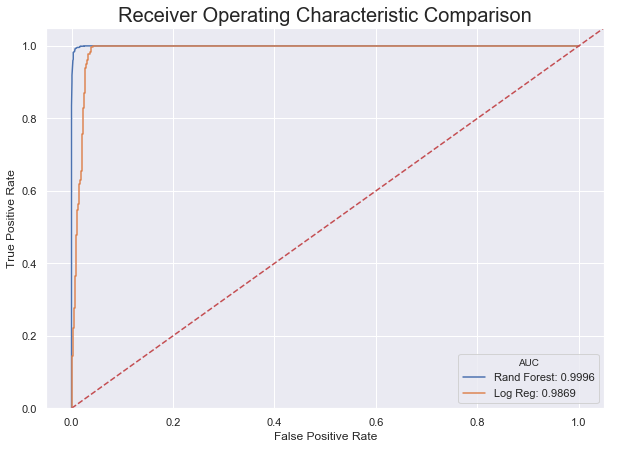

In [54]:
_ = plt.figure(figsize=(10,7))
_ = plt.title('Receiver Operating Characteristic Comparison', size=20)
_ = plt.plot(fprrfc, tprrfc, label='Rand Forest: %0.4f' % roc_aucrfc)
_ = plt.plot(fprlr, tprlr, label='Log Reg: %0.4f' % roc_auclr)
_ = plt.legend(title='AUC', loc = 'lower right')
_ = plt.plot([0, 1.05], [0, 1.05],'r--')
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([0, 1.05])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')
_ = plt.show()

## Applying model to original data

I am going to apply this model to my original data and see how accurate it is at predicting on new data.

In [55]:
features = wq_df.loc[:, best_features_test.columns]
features = features.drop(index=best_features_test.index)
target = chl_overlap_df['BB2_fail_overlap_chl']
target = target.drop(index=best_features_test.index)

x_train, x_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=.3,
                                                    random_state=42)

In [56]:
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

print(classification_report(y_test, y_pred))
print('Random Forest F1 Score: ', f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6551
           1       0.90      0.20      0.32        46

    accuracy                           0.99      6597
   macro avg       0.95      0.60      0.66      6597
weighted avg       0.99      0.99      0.99      6597

Random Forest F1 Score:  0.3214285714285714


In [57]:
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)

print(classification_report(y_test, y_pred))
print('Random Forest F1 Score: ', f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6551
           1       0.50      0.04      0.08        46

    accuracy                           0.99      6597
   macro avg       0.75      0.52      0.54      6597
weighted avg       0.99      0.99      0.99      6597

Random Forest F1 Score:  0.08


# Discussion

The model did terrible on the real world data. Potential reasons for this:

- **Leakage** from training data into test data would result in overfitting and poor application to new data
- **Incorrect assumptions** may have been made about the relationships between sites which would greatly impact the ability of my produced models to perform on the real world data.

Performing Root Cause Analysis could help me to locate where the error originates.

In [ ]:
full_overlap_df_pho = wq_df.join(pho_overlap_df, rsuffix='_r')
full_overlap_df_pho.drop(columns=['Sampling Location_r', 'Sample Time',
                                  'Sample Date', 'Sampling Location'], inplace=True)

I am going to take the top 10 sites from the phosphate heatmap based on the sum of their probabilities and develop a geospatial representation of their likelihoods.

In [ ]:
pho_means_df.sum(axis=0).sort_values(ascending=False)[:10]

In order to perform kriging, data has to be normal. I transform the numeric value of Ortho-phosphorus using np.log.

In [ ]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L) Failure'])
krige_df['Top Ortho-Phosphorus (mg/L)'] = krige_df['Top Ortho-Phosphorus (mg/L)'].apply(np.log)

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L)']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L)'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


Based on these scores, the best model is the Random Forest Regressor as it has the highest Regression Score. Approximately 64% of the variance is explained with this model.

In [ ]:
residuals = fitted_models['RandomForestRegressor'].krige_residual(x)
_ = sns.residplot(target, residuals, lowess=True)

I want to now do this with the binary classifier and see what the regression results look like.

In [ ]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L)'])

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L) Failure']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L) Failure'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


The Random Forest Regressor is still the best classifier, but I want to inspect the predicted values.

In [ ]:
rf_rk = RegressionKriging(regression_model=rf_model, n_closest_points=10)
rf_rk.fit(p_train, x_train, target_train)
target_pred = rf_rk.predict(p_test, x_test)

While my model has very high accuracy, but since it is unbalanced, it is not fair to use accuracy as the metric. I will look at F1 score instead which takes into account false positives and negatives as well.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
print('Accuracy: ', accuracy_score(target_test, (target_pred > 0.5)))
print('F1 Score: ',f1_score(target_test, (target_pred > 0.5)))
print(classification_report(target_test, (target_pred > 0.5)))


I am creating a dataframe containing information on where each location failure overlaps with failures of another site. I am looking at phosphate in this dataframe. My intention is to iterate through each of the 